# Problem Statement
HELP International is an international humanitarian NGO that is committed to fighting poverty and providing the people of backward countries with basic amenities and relief during the time of disasters and natural calamities.

They have been able to raise around $ 10 million. Now the CEO of the NGO needs to decide how to use this money strategically and effectively. The significant issues that come while making this decision are mostly related to choosing the countries that are in the direst need of aid.

We need to categorise the countries using some socio-economic and health factors that determine the overall development of the country and suggest the countries on which the CEO needs to focus on the most. 

## Read and Inspect Data

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [6]:
#Reading the dataset.
countries = pd.read_csv("Country-data.csv", sep=",", encoding="ISO-8859-1", header=0)
countries.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [7]:
# Inspect
countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [8]:
# Checking for missing values.
round(100*(countries.isnull().sum())/len(countries), 2)

country       0.0
child_mort    0.0
exports       0.0
health        0.0
imports       0.0
income        0.0
inflation     0.0
life_expec    0.0
total_fer     0.0
gdpp          0.0
dtype: float64

#### We can see that there are no missing values in the data.

## Data Understanding

We know that the variables 'exports', 'health' and 'imports' are given as percentage of GDP per capita. Let's convert them to actual values.

In [9]:
# Coverting the variable exports to actual values
countries['exports']=(countries['exports']/100)*countries['gdpp']

In [10]:
countries.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,6.03,58.9,19100,1.44,76.8,2.13,12200


In [11]:
# Coverting the variable health 
countries['health']=(countries['health']/100)*countries['gdpp']

In [12]:
# Converting the variable imports
countries['imports']=(countries['imports']/100)*countries['gdpp']

In [13]:
countries.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


## EDA

In [14]:
Features = ['child_mort','exports','health','imports','income','inflation','life_expec','total_fer','gdpp']

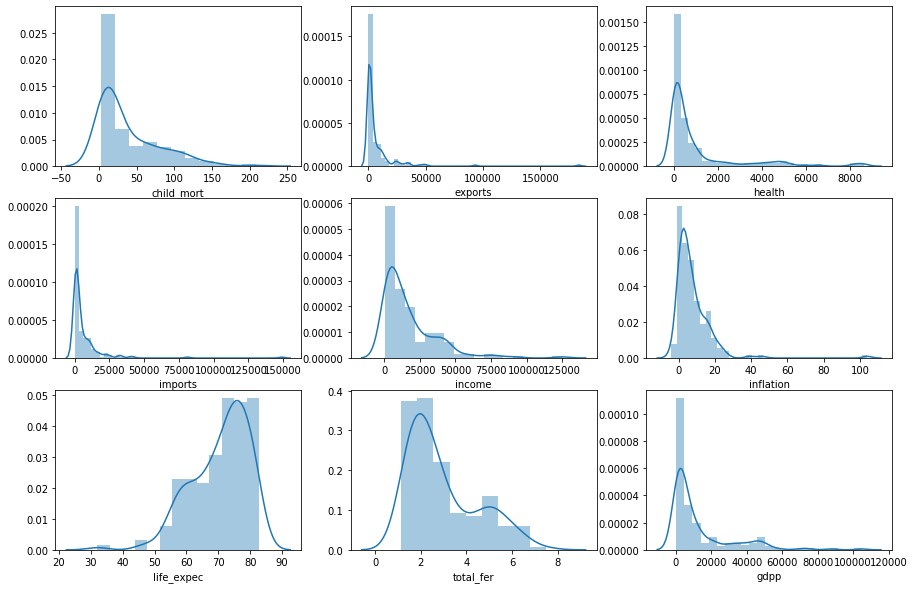

In [15]:
plt.figure(figsize = (15, 10))
for i in enumerate(Features):
    plt.subplot(3,3,i[0]+1)
    sns.distplot(countries[i[1]])
plt.show()

## Data Preparation

### Outlier Analysis

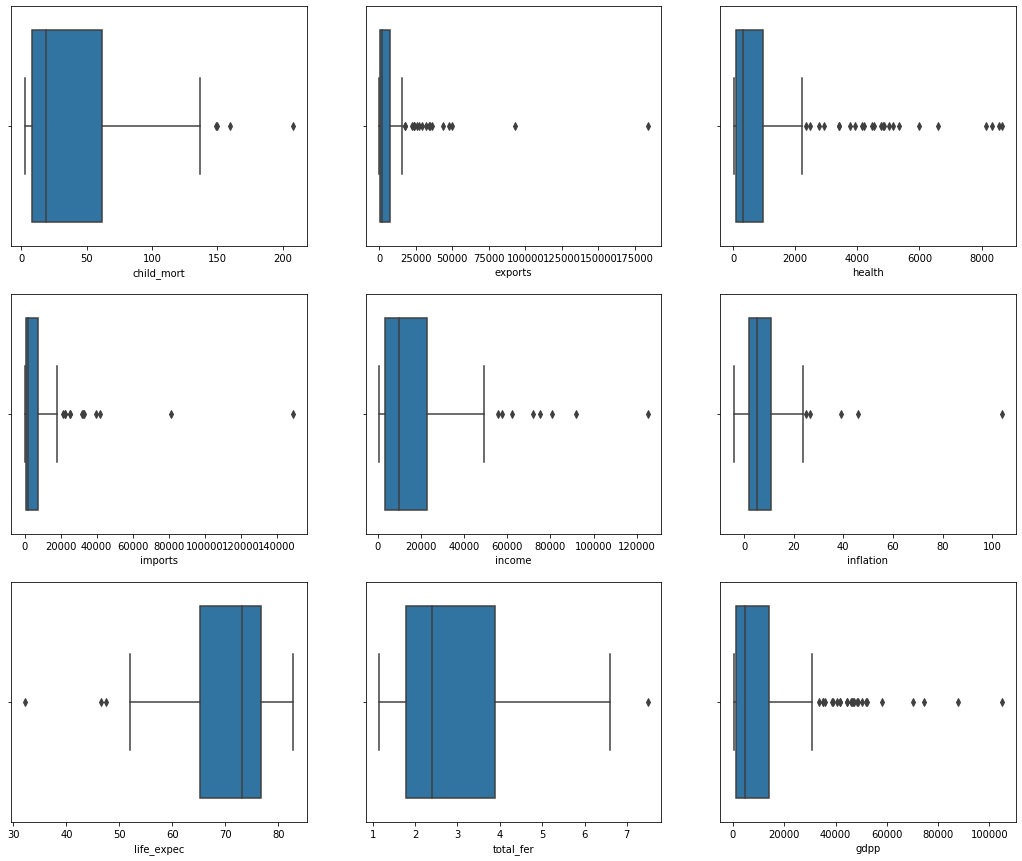

In [16]:
plt.figure(figsize = (18, 15))
for i in enumerate(Features):
    plt.subplot(3,3,i[0]+1)
    sns.boxplot(countries[i[1]])
plt.show()

**We can see that there are more outliers in the variables - exports, imports, income, inflation and gdpp. The rest of the variables either have very few outliers or have outliers that do not have a lot of distance between other data points. Hence, we choose to treat the outliers for the variables having more outliers.**

In [17]:
# Outliers in 'exports'
print(countries['exports'].quantile([.90,.95,.96,.97,.98,.99,1]))

0.90     17760.600
0.95     31385.100
0.96     34258.200
0.97     36367.618
0.98     46480.928
0.99     64794.260
1.00    183750.000
Name: exports, dtype: float64


> We can see that there is lot of difference between the 99th quantile and the 100th quantile. Let's cap the values at the 99th quantile.

In [18]:
# Capping outliers in exports
countries.loc[countries.exports > countries.exports.quantile(.99),"exports"] = countries.exports.quantile(.99)

In [19]:
print(countries['exports'].quantile([.90,.95,.96,.97,.98,.99,1]))

0.90    17760.6000
0.95    31385.1000
0.96    34258.2000
0.97    36367.6180
0.98    46480.9280
0.99    55136.3084
1.00    64794.2600
Name: exports, dtype: float64


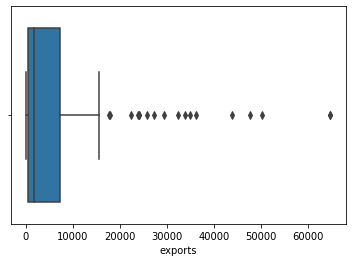

In [20]:
# Visualising box plots for 'exports'
sns.boxplot(countries['exports'])

> We can still see some outliers but because we are not doing a harsh outlier treatment, we will not treat these outliers.

In [21]:
# Outliers in 'imports'
print(countries['imports'].quantile([.90,.95,.96,.97,.98,.99,1]))

0.90     15034.280
0.95     24241.560
0.96     27701.008
0.97     32507.456
0.98     37651.400
0.99     55371.390
1.00    149100.000
Name: imports, dtype: float64


> We can see that there is lot of difference between the 99th quantile and the 100th quantile. Let's cap the values at the 99th quantile.

In [22]:
# Capping outliers for imports
countries.loc[countries.imports>countries.imports.quantile(.99),"imports"] = countries.imports.quantile(.99)

In [23]:
print(countries['imports'].quantile([.90,.95,.96,.97,.98,.99,1]))

0.90    15034.2800
0.95    24241.5600
0.96    27701.0080
0.97    32507.4560
0.98    37651.4000
0.99    46629.1026
1.00    55371.3900
Name: imports, dtype: float64


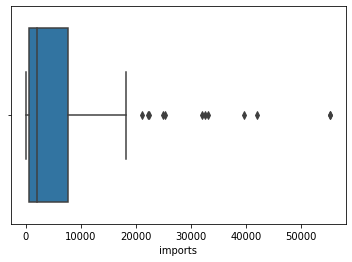

In [24]:
# Visualising box plots for 'imports'
sns.boxplot(countries['imports'])

> We can still see some outliers but because we are not doing a harsh outlier treatment, we will not treat these outliers.

In [25]:
# Outliers in 'income'
print(countries['income'].quantile([.90,.95,.96,.97,.98,.99,1]))

0.90     41220.0
0.95     48290.0
0.96     56256.0
0.97     62496.0
0.98     74208.0
0.99     84374.0
1.00    125000.0
Name: income, dtype: float64


> We can see that there is lot of difference between the 99th quantile and the 100th quantile. Let's cap the values at the 99th quantile.

In [26]:
# Capping outliers for income
countries.loc[countries.income>countries.income.quantile(.99),"income"] = countries.income.quantile(.99)

In [27]:
print(countries['income'].quantile([.90,.95,.96,.97,.98,.99,1]))

0.90    41220.00
0.95    48290.00
0.96    56256.00
0.97    62496.00
0.98    74208.00
0.99    81883.16
1.00    84374.00
Name: income, dtype: float64


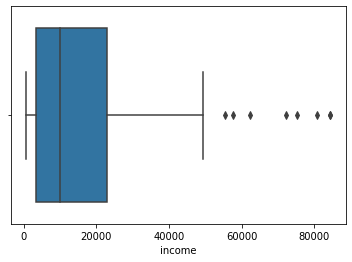

In [28]:
# Visualising box plots for 'income'
sns.boxplot(countries['income'])

> We can still see some outliers but because we are not doing a harsh outlier treatment, we will not treat these outliers.

In [29]:
# Outliers in 'inflation'
print(countries['inflation'].quantile([.90,.95,.96,.97,.98,.99,1]))

0.90     16.640
0.95     20.870
0.96     22.544
0.97     23.626
0.98     25.988
0.99     41.478
1.00    104.000
Name: inflation, dtype: float64


> We can see that there is lot of difference between the 99th quantile and the 100th quantile. Let's cap the values at the 99th quantile.

In [30]:
# Capping outliers for inflation
countries.loc[countries.inflation>countries.inflation.quantile(.99),"inflation"] = countries.inflation.quantile(.99)

In [31]:
print(countries['inflation'].quantile([.90,.95,.96,.97,.98,.99,1]))

0.90    16.64000
0.95    20.87000
0.96    22.54400
0.97    23.62600
0.98    25.98800
0.99    39.97452
1.00    41.47800
Name: inflation, dtype: float64


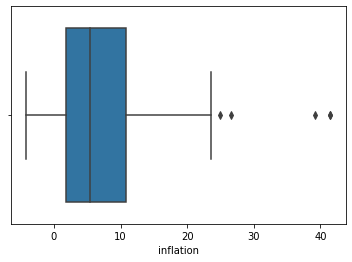

In [32]:
# Visualising box plots for 'inflation'
sns.boxplot(countries['inflation'])

> We can still see some outliers but because we are not doing a harsh outlier treatment, we will not treat these outliers.

In [33]:
# Outliers in 'gdpp'
print(countries['gdpp'].quantile([.90,.95,.96,.97,.98,.99,1]))

0.90     41840.0
0.95     48610.0
0.96     50876.0
0.97     52218.0
0.98     66364.0
0.99     79088.0
1.00    105000.0
Name: gdpp, dtype: float64


> We can see that there is lot of difference between the 99th quantile and the 100th quantile. Let's cap the values at the 99th quantile.

In [34]:
# Capping outliers for gdpp
countries.loc[countries.gdpp>countries.gdpp.quantile(.99),"gdpp"] = countries.gdpp.quantile(.99)

In [35]:
print(countries['gdpp'].quantile([.90,.95,.96,.97,.98,.99,1]))

0.90    41840.00
0.95    48610.00
0.96    50876.00
0.97    52218.00
0.98    66364.00
0.99    76125.92
1.00    79088.00
Name: gdpp, dtype: float64


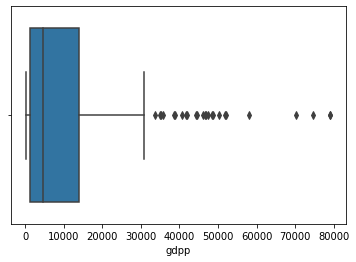

In [36]:
# Visualising box plots for 'gdpp'
sns.boxplot(countries['gdpp'])

> We can still see some outliers but because we are not doing a harsh outlier treatment, we will not treat these outliers.

### Scaling the Data

In [37]:
# Creating another dataframe with only the continuous variables, i.e, without the 'Countries' column.
df = countries[Features]

In [38]:
df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0
1,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0
2,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0
3,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0
4,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0


In [39]:
# instantiate
scaler = StandardScaler()

# fit_transform
df_scaled = scaler.fit_transform(df)
df_scaled.shape

(167, 9)

In [40]:
#Converting df_scaled to a dataframe
df_scaled = pd.DataFrame(df_scaled)

In [41]:
df_scaled.columns = Features
df_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,-0.569622,-0.565040,-0.598741,-0.851668,0.265002,-1.619092,1.902882,-0.702259
1,-0.538949,-0.473858,-0.439218,-0.413584,-0.386946,-0.372075,0.647866,-0.859973,-0.498726
2,-0.272833,-0.424000,-0.484826,-0.476100,-0.221053,1.122161,0.670423,-0.038404,-0.477434
3,2.007808,-0.381249,-0.532363,-0.463973,-0.612045,1.932987,-1.179234,2.128151,-0.530950
4,-0.695634,-0.086742,-0.178771,0.139728,0.125254,-0.764618,0.704258,-0.541946,-0.032042


### Hopkins Check

In [42]:
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [46]:
hopkins(df_scaled)

0.890600234483995

**After running the Hopkin's Test for multiple time, the values were as follows:**

1. 0.890600234483995
2. 0.9070995628235266
3. 0.9101133209196035
3. 0.9240498137545636

>**Looking at these values, we can say that there is a good clustering tendency.**

## K-Means Clustering

### Choosing the value of K, using Elbow Curve

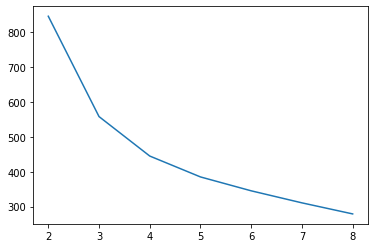

[[2, 845.7448305942528], [3, 558.0805247193724], [4, 444.9558245770552], [5, 385.0577151803699], [6, 345.24972802703485], [7, 310.75357984773893], [8, 279.0375019919526]]


In [105]:
#Elbow curve/ SSD - Sum of Squared Distance
ssd = []
for k in range(2, 9):
    model= KMeans(n_clusters = k).fit(df_scaled)
    ssd.append([k, model.inertia_])
    
plt.plot(pd.DataFrame(ssd)[0], pd.DataFrame(ssd)[1])
plt.show()
print(ssd)

> **Looking at the elbow curve, the optimum value of K would be 3, as the SSD drops very significantly at the value 3 and after 3, the rate of drop is not so signicant.**

### Choosing the value of K, using Silhouette Score

In [106]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    

For n_clusters=2, the silhouette score is 0.4692635922798523
For n_clusters=3, the silhouette score is 0.4026509948337951
For n_clusters=4, the silhouette score is 0.39101520604069373
For n_clusters=5, the silhouette score is 0.3832861834526914
For n_clusters=6, the silhouette score is 0.2932043454466285
For n_clusters=7, the silhouette score is 0.29016250739356775
For n_clusters=8, the silhouette score is 0.2912906943511318


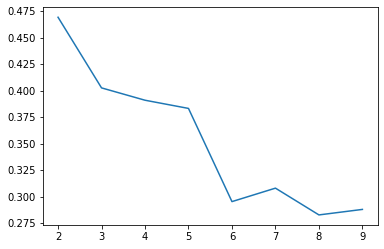

In [107]:
sscore = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters = k).fit(df_scaled)
    sscore.append([k, silhouette_score(df_scaled, kmeans.labels_)])
    
plt.plot(pd.DataFrame(sscore)[0], pd.DataFrame(sscore)[1])
plt.show()

> **We can see that the highest Silhoutte score is 0.4692 at K = 2, but having just two clusters would not help us with the analysis that we have here, hence, lets go with the next best score which is 0.4026 at K=3.**

**Now, looking at the Elbow Score and the Silhoutte Score, we can say the optimal value of K would be equal to 3.**

### Running K-Means with K = 3

In [108]:
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [109]:
kmeans.labels_

array([1, 2, 2, 1, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 2, 2, 1,
       2, 0, 2, 1, 1, 2, 1, 0, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 1, 1, 2, 2, 0, 0, 1, 1, 2, 0, 1, 2, 2, 2, 1, 1, 2,
       1, 2, 0, 2, 2, 2, 1, 0, 2, 0, 2, 0, 2, 2, 1, 1, 0, 2, 1, 2, 2, 1,
       1, 2, 2, 0, 2, 1, 1, 2, 2, 1, 0, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2,
       0, 0, 1, 1, 0, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 1, 2, 2,
       1, 0, 2, 0, 1, 1, 2, 0, 2, 2, 1, 2, 0, 0, 2, 1, 2, 1, 1, 2, 2, 2,
       2, 1, 2, 0, 0, 0, 2, 2, 2, 2, 2, 1, 1], dtype=int32)

In [110]:
# Concating clustering labels with the orginal dataframe.
countries_km = pd.concat([countries, pd.Series(kmeans.labels_)], axis =1)
countries_km.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,0
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,1
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,2
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,2
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,1
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,2


In [111]:
countries_km.columns = ['country', 'child_mort', 'exports', 'health', 'imports', 'income','inflation', 'life_expec',
                 'total_fer', 'gdpp','label']
countries_km.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,1
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,2
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,2
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,1
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,2


In [112]:
countries_km.label.value_counts()

2    90
1    48
0    29
Name: label, dtype: int64

### Visualization of Clusters
Let's visualize the clusters based on the variables **'gdpp, child_mort and income'**

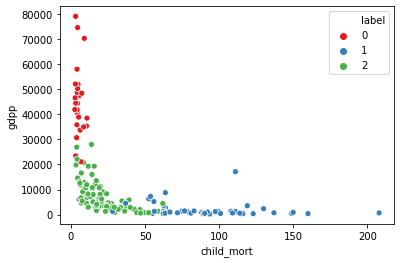

In [113]:
sns.scatterplot(x = "child_mort" , y = "gdpp", hue = 'label', data = countries_km, palette = "Set1")
plt.show()

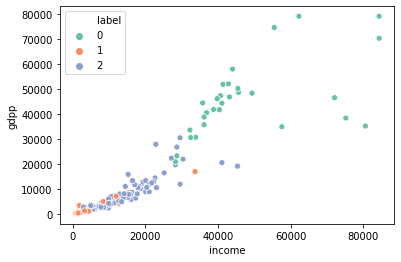

In [114]:
sns.scatterplot(x = "income" , y = "gdpp", hue = 'label', data = countries_km, palette = "Set2")
plt.show()

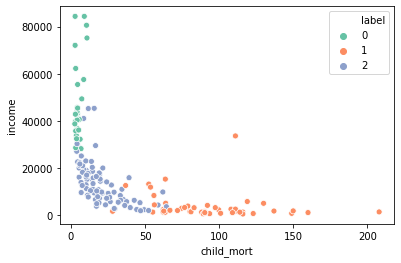

In [115]:
sns.scatterplot(x = "child_mort" , y = "income", hue = 'label', data = countries_km, palette = "Set2")
plt.show()

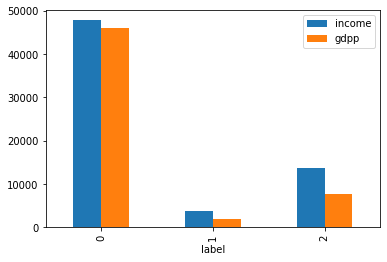

In [116]:
countries_km[['income','gdpp','label']].groupby("label").mean().plot(kind = 'bar')
plt.show()

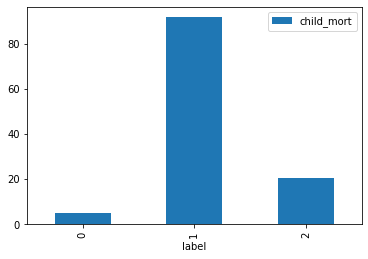

In [117]:
countries_km[['child_mort','label']].groupby("label").mean().plot(kind = 'bar')
plt.show()

> **Looking at the bar plot we can see that cluster labelled 1 is having highest child_mortality rate, low income and low gdpp, which means it includes the countries which are in need of aid from the organization HELP.**

### List of Countries, that have High Child Mortality rate, Low Income and Low GDPP

In [129]:
#Sorting the countries in cluster 1 by high child mortality rate, low income and low gdpp.
countries_km[countries_km['label']==1].sort_values(by = ['income', 'child_mort','gdpp'], ascending = [True, False , True])

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
37,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609.0,20.800,57.5,6.54,334.0,1
88,Liberia,89.3,62.4570,38.5860,302.802,700.0,5.470,60.8,5.02,327.0,1
26,Burundi,93.6,20.6052,26.7960,90.552,764.0,12.300,57.7,6.26,231.0,1
112,Niger,123.0,77.2560,17.9568,170.868,814.0,2.550,58.8,7.49,348.0,1
31,Central African Republic,149.0,52.6280,17.7508,118.190,888.0,2.010,47.5,5.21,446.0,1
106,Mozambique,101.0,131.9850,21.8299,193.578,918.0,7.640,54.5,5.56,419.0,1
94,Malawi,90.5,104.6520,30.2481,160.191,1030.0,12.100,53.1,5.31,459.0,1
63,Guinea,109.0,196.3440,31.9464,279.936,1190.0,16.100,58.0,5.34,648.0,1
150,Togo,90.3,196.1760,37.3320,279.624,1210.0,1.180,58.7,4.87,488.0,1
132,Sierra Leone,160.0,67.0320,52.2690,137.655,1220.0,17.200,55.0,5.20,399.0,1


### Country Identification
#### The top 5 countries which are in direst need of aid based on the K-Means Clustering are:
1. Congo, Dem. Rep.
2. Liberia
3. Burundi
4. Niger
5. Central African Republic

## Hierarchical Clustering

In [119]:
# Using the scaled data
df_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,-0.569622,-0.565040,-0.598741,-0.851668,0.265002,-1.619092,1.902882,-0.702259
1,-0.538949,-0.473858,-0.439218,-0.413584,-0.386946,-0.372075,0.647866,-0.859973,-0.498726
2,-0.272833,-0.424000,-0.484826,-0.476100,-0.221053,1.122161,0.670423,-0.038404,-0.477434
3,2.007808,-0.381249,-0.532363,-0.463973,-0.612045,1.932987,-1.179234,2.128151,-0.530950
4,-0.695634,-0.086742,-0.178771,0.139728,0.125254,-0.764618,0.704258,-0.541946,-0.032042


### Single Linkage

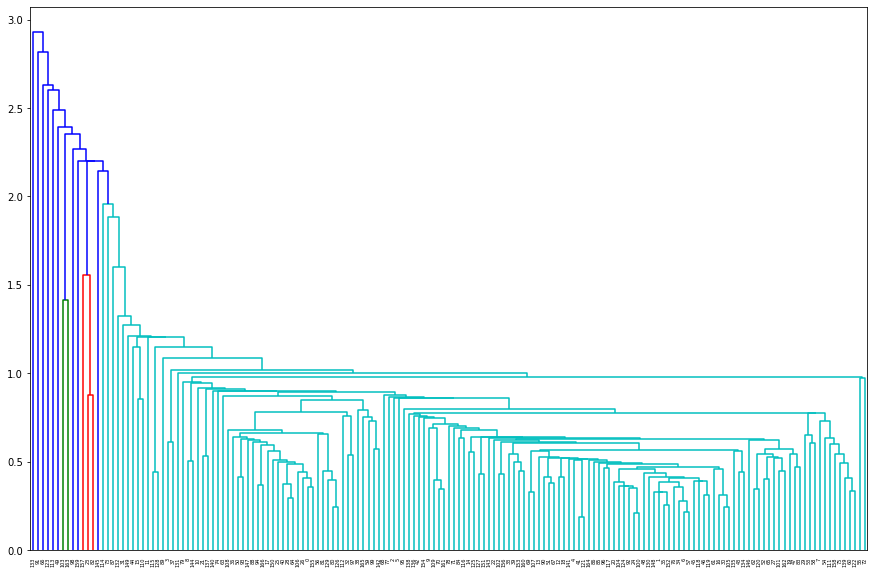

In [120]:
# Single Linkage
plt.figure(figsize=(15,10))
mergings = linkage(df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

### Complete Linkage

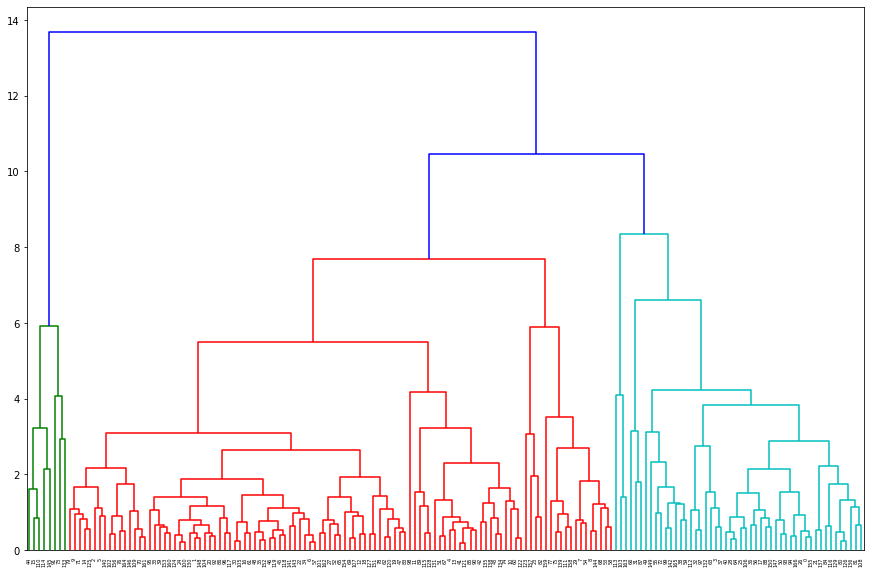

In [121]:
# complete linkage
plt.figure(figsize=(15,10))
mergings = linkage(df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

**Based on Complete Linkage we can choose k = 3.**

In [122]:
#3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       2, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 2, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       2, 1, 0, 0, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 2, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 2, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0])

In [123]:
# assigning cluster labels to the orginal data
countries['cluster_labels'] = cluster_labels
countries.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_labels
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,1
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,1
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,1


In [124]:
countries.cluster_labels.value_counts()

1    109
0     50
2      8
Name: cluster_labels, dtype: int64

### Visualization of Clusters

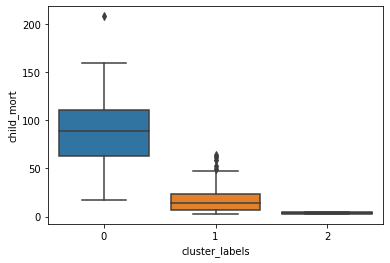

In [125]:
# child_mort
sns.boxplot(x='cluster_labels', y='child_mort', data=countries)
plt.show()

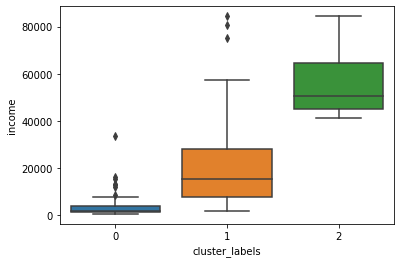

In [126]:
# income
sns.boxplot(x='cluster_labels', y='income', data=countries)

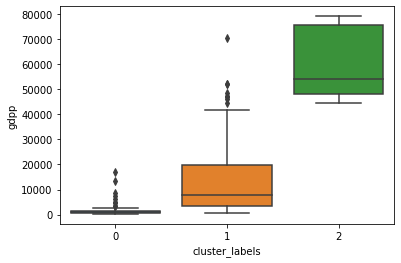

In [127]:
# gdpp
sns.boxplot(x='cluster_labels', y='gdpp', data=countries)

> **Looking at the box plots we can see that the cluster with high child mortality, low income and low gdpp is cluster labelled 0.**

### List of Countries, that have High Child Mortality rate, Low Income and Low GDPP

In [128]:
#Sorting the countries in cluster 1 by high child mortality rate, low income and low gdpp.
countries[countries['cluster_labels']==0].sort_values(by = ['income', 'child_mort','gdpp'], ascending = [True, False , True])

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_labels
37,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609.0,20.800,57.5,6.54,334.0,0
88,Liberia,89.3,62.4570,38.5860,302.802,700.0,5.470,60.8,5.02,327.0,0
26,Burundi,93.6,20.6052,26.7960,90.552,764.0,12.300,57.7,6.26,231.0,0
112,Niger,123.0,77.2560,17.9568,170.868,814.0,2.550,58.8,7.49,348.0,0
31,Central African Republic,149.0,52.6280,17.7508,118.190,888.0,2.010,47.5,5.21,446.0,0
106,Mozambique,101.0,131.9850,21.8299,193.578,918.0,7.640,54.5,5.56,419.0,0
94,Malawi,90.5,104.6520,30.2481,160.191,1030.0,12.100,53.1,5.31,459.0,0
63,Guinea,109.0,196.3440,31.9464,279.936,1190.0,16.100,58.0,5.34,648.0,0
150,Togo,90.3,196.1760,37.3320,279.624,1210.0,1.180,58.7,4.87,488.0,0
132,Sierra Leone,160.0,67.0320,52.2690,137.655,1220.0,17.200,55.0,5.20,399.0,0


### Country Identification
#### The top 5 countries which are in direst need of aid based on the K-Means Clustering are:
1. Congo, Dem. Rep.
2. Liberia
3. Burundi
4. Niger
5. Central African Republic